In [5]:
START
 ↓
Node 1: Query Resume Vector DB (Profile Extraction)
 ↓
Node 2: Build Job Search Plan
 ↓
Node 3A: Fetch Jobs from Email Alerts
 ↓
Node 3B: Fetch Jobs from Career APIs
 ↓
Node 3C: Merge & Deduplicate
 ↓
Node 4: Parse Job Descriptions
 ↓
Node 5: Match Resume ↔ Jobs (RAG)
 ↓
Node 6: Rank & Filter
 ↓
Node 7: Generate Cover Letters (RAG)
 ↓
Node 8: Save to Google Sheets
 ↓
END


IndentationError: unexpected indent (3161048044.py, line 2)

*step 1:
* [ Resume Upload ]
        ↓
* [ Text Extraction ]
        ↓
* [ Chunk + Embed ]
        ↓
* [ Vector Store ]  ←── persistent memory
        ↓
* ──────────────────────────────────
        ↓
* [ LangGraph Agent ]

step 2:
Node 1: Fetch Candidate Profile (RAG Query Node)

Purpose:
Query vector DB to understand the candidate.

What it does

Queries resume embeddings

Uses LLM to extract:

Skills

Experience

Preferred roles

Location

Input

{
  "query": "Extract skills, experience, roles, and locations from resume"
}


Output (state)

{
  "skills": ["Python", "ML", "FastAPI"],
  "experience_level": "Fresher / Intern",
  "preferred_roles": ["ML Intern", "Backend Intern"],
  "locations": ["India", "Remote"]
}


📌 This is the FIRST node in the graph

🟦 Node 2: Build Job Search Plan (Planner Node)

Uses:

Skills

Roles

Locations

Produces:

search_queries = [
  "Machine Learning Intern India",
  "Backend Intern Python Remote"
]


🧠 Agent decides how to search

🟦 Node 3A: Fetch Jobs from EMAIL ALERTS (Tool)

Reads Gmail inbox

Extracts job postings

No thinking, only execution

🟦 Node 3B: Fetch Jobs from COMPANY CAREER APIs (Tool)

Calls public career endpoints

Uses search_queries

🟦 Node 3C: Merge & Deduplicate Jobs

Combines:

Email jobs

Career API jobs

🟦 Node 4: Parse & Normalize Jobs (LLM)

Extracts:

Required skills

Experience

Keywords

🟦 Node 5: Match Resume ↔ Jobs (RAG + Embeddings)

Queries vector DB again:

Compares job description ↔ resume

Computes relevance score

🟦 Node 6: Rank & Filter Jobs

Agent decision:

Sort

Remove low relevance jobs

🟦 Node 7: Generate Cover Letters (RAG + LLM)

Uses:

Resume memory (vector DB)

Job description

Generates custom letter per job

🟦 Node 8: Save to Google Sheets (Tool)

Stores:
| Company | Role | Match % | Link | Cover Letter |


In [3]:
# job_agent_graph.py

from typing import List, Dict, Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, END
from langchain_core.tools import tool

# =========================================================
# STATE DEFINITION
# =========================================================

class JobAgentState(TypedDict):
    skills: List[str]
    experience_level: str
    preferred_roles: List[str]
    locations: List[str]

    search_queries: List[str]

    raw_jobs: List[Dict[str, Any]]
    parsed_jobs: List[Dict[str, Any]]
    scored_jobs: List[Dict[str, Any]]
    ranked_jobs: List[Dict[str, Any]]

    cover_letters: Dict[str, str]


# =========================================================
# DUMMY NODE FUNCTIONS (NO REAL LOGIC)
# =========================================================

def extract_candidate_profile(state: JobAgentState) -> JobAgentState:
    return {
        **state,
        "skills": ["Python", "Machine Learning", "FastAPI"],
        "experience_level": "Intern / Fresher",
        "preferred_roles": ["ML Intern", "Backend Intern"],
        "locations": ["India", "Remote"]
    }


def build_job_search_plan(state: JobAgentState) -> JobAgentState:
    return {
        **state,
        "search_queries": [
            "Machine Learning Intern India",
            "Backend Intern Python Remote"
        ]
    }


def parse_jobs(state: JobAgentState) -> JobAgentState:
    return {
        **state,
        "parsed_jobs": state.get("raw_jobs", [])
    }


def match_jobs(state: JobAgentState) -> JobAgentState:
    return {
        **state,
        "scored_jobs": state.get("parsed_jobs", [])
    }


def rank_jobs(state: JobAgentState) -> JobAgentState:
    return {
        **state,
        "ranked_jobs": state.get("scored_jobs", [])
    }


def generate_cover_letters(state: JobAgentState) -> JobAgentState:
    return {
        **state,
        "cover_letters": {
            "job_1": "This is a dummy personalized cover letter."
        }
    }


def save_to_google_sheets(state: JobAgentState) -> JobAgentState:
    print("✅ Saving results to Google Sheets (dummy)")
    return state


# =========================================================
# TOOL DEFINITIONS (CORRECT FORMAT)
# =========================================================

@tool
def fetch_jobs_from_email(search_query: str) -> List[Dict[str, Any]]:
    """Fetch jobs from email alerts (dummy)"""
    return [
        {
            "company": "ABC Tech",
            "role": "ML Intern",
            "source": "Email Alert",
            "query": search_query
        }
    ]


@tool
def fetch_jobs_from_career_api(search_query: str) -> List[Dict[str, Any]]:
    """Fetch jobs from company career APIs (dummy)"""
    return [
        {
            "company": "XYZ Corp",
            "role": "Backend Intern",
            "source": "Career API",
            "query": search_query
        }
    ]


@tool
def merge_and_deduplicate_jobs(
    email_jobs: List[Dict[str, Any]],
    api_jobs: List[Dict[str, Any]]
) -> List[Dict[str, Any]]:
    """Merge and deduplicate job results (dummy)"""
    return email_jobs + api_jobs


# =========================================================
# TOOL NODE (EXECUTOR)
# =========================================================

def fetch_jobs_toolnode(state: JobAgentState) -> JobAgentState:
    all_jobs = []

    for query in state["search_queries"]:
        email_jobs = fetch_jobs_from_email.invoke(query)
        api_jobs = fetch_jobs_from_career_api.invoke(query)

        merged_jobs = merge_and_deduplicate_jobs.invoke(
            {
                "email_jobs": email_jobs,
                "api_jobs": api_jobs
            }
        )

        all_jobs.extend(merged_jobs)

    return {
        **state,
        "raw_jobs": all_jobs
    }


# =========================================================
# LANGGRAPH DEFINITION
# =========================================================

graph = StateGraph(JobAgentState)

# ---- Nodes ----
graph.add_node("extract_candidate_profile", extract_candidate_profile)
graph.add_node("build_job_search_plan", build_job_search_plan)
graph.add_node("fetch_jobs", fetch_jobs_toolnode)
graph.add_node("parse_jobs", parse_jobs)
graph.add_node("match_jobs", match_jobs)
graph.add_node("rank_jobs", rank_jobs)
graph.add_node("generate_cover_letters", generate_cover_letters)
graph.add_node("save_to_google_sheets", save_to_google_sheets)

# ---- Edges ----
graph.set_entry_point("extract_candidate_profile")

graph.add_edge("extract_candidate_profile", "build_job_search_plan")
graph.add_edge("build_job_search_plan", "fetch_jobs")
graph.add_edge("fetch_jobs", "parse_jobs")
graph.add_edge("parse_jobs", "match_jobs")
graph.add_edge("match_jobs", "rank_jobs")
graph.add_edge("rank_jobs", "generate_cover_letters")
graph.add_edge("generate_cover_letters", "save_to_google_sheets")
graph.add_edge("save_to_google_sheets", END)

job_agent_graph = graph.compile()


# =========================================================
# OPTIONAL: VISUALIZE GRAPH
# =========================================================


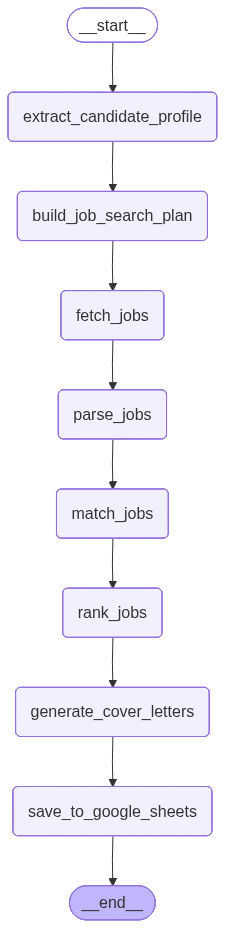

In [4]:
job_agent_graph

In [2]:
langgraph dev

SyntaxError: invalid syntax (436740464.py, line 1)